In [15]:
import seisbench.models as sbm
import seisbench.data as sbd
import seisbench.generate as sbg
from seisbench.util import worker_seeding

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from obspy.clients.fdsn import Client
from obspy import UTCDateTime

In [3]:
data = sbd.ETHZ(sampling_rate=50, force=True)
train, dev, test = data.train_dev_test()

2025-05-16 10:46:46,298 | seisbench | WARNING | Check available storage and memory before downloading and general use of ETHZ dataset. Dataset size: waveforms.hdf5 ~22Gb, metadata.csv ~13Mb
2025-05-16 10:46:47,724 | seisbench | WARNING | Dataset ETHZ not in cache.
2025-05-16 10:46:47,725 | seisbench | WARNING | Trying to download preprocessed version from SeisBench repository.
2025-05-16 12:10:24,473 | seisbench | WARNING | Output component order not specified, defaulting to 'ZNE'.


In [5]:
model = sbm.VariableLengthPhaseNet(in_samples=601, sampling_rate=50)
if torch.cuda.is_available():
    model.cuda()
    print("Running on GPU")
else:
    print("Running on CPU")

Running on GPU


In [6]:
phase_dict = {
    "trace_p_arrival_sample": "P",
    "trace_pP_arrival_sample": "P",
    "trace_P_arrival_sample": "P",
    "trace_P1_arrival_sample": "P",
    "trace_Pg_arrival_sample": "P",
    "trace_Pn_arrival_sample": "P",
    "trace_PmP_arrival_sample": "P",
    "trace_pwP_arrival_sample": "P",
    "trace_pwPm_arrival_sample": "P",
    "trace_s_arrival_sample": "S",
    "trace_S_arrival_sample": "S",
    "trace_S1_arrival_sample": "S",
    "trace_Sg_arrival_sample": "S",
    "trace_SmS_arrival_sample": "S",
    "trace_Sn_arrival_sample": "S",
}
train_generator = sbg.GenericGenerator(train)
dev_generator = sbg.GenericGenerator(dev)

augmentations = [
    sbg.WindowAroundSample(list(phase_dict.keys()), samples_before=1500, windowlen=3000, selection="random", strategy="variable"),
    sbg.RandomWindow(windowlen=601, strategy="pad"),
    sbg.Normalize(demean_axis=-1, amp_norm_axis=-1, amp_norm_type="peak"),
    sbg.ChangeDtype(np.float32),
    sbg.ProbabilisticLabeller(label_columns=phase_dict, model_labels=model.labels, sigma=30, dim=0)
]

train_generator.add_augmentations(augmentations)
dev_generator.add_augmentations(augmentations)

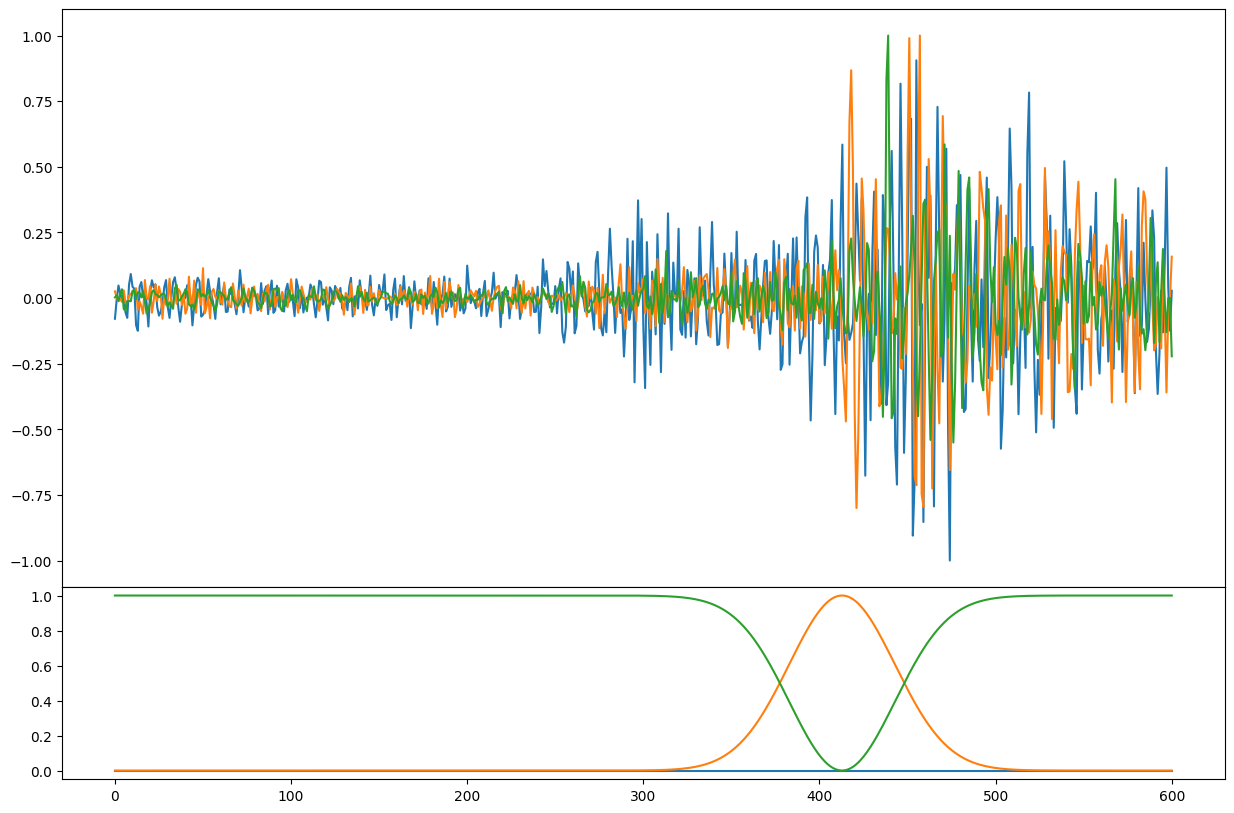

In [11]:
sample = train_generator[np.random.randint(len(train_generator))]

fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(2, 1, sharex=True, gridspec_kw={"hspace": 0, "height_ratios": [3, 1]})
axs[0].plot(sample["X"].T)
axs[1].plot(sample["y"].T)

In [49]:
batch_size = 256
num_workers = 6  # The number of threads used for loading data

train_loader = DataLoader(train_generator, batch_size=batch_size, shuffle=True, num_workers=num_workers, worker_init_fn=worker_seeding)
dev_loader = DataLoader(dev_generator, batch_size=batch_size, shuffle=False, num_workers=num_workers, worker_init_fn=worker_seeding)

In [52]:
learning_rate = 1e-2
epochs = 10

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

def loss_fn(y_pred, y_true, eps=1e-5):
    # vector cross entropy loss
    h = y_true * torch.log(y_pred + eps)
    h = h.mean(-1).sum(-1)  # Mean along sample dimension and sum along pick dimension
    h = h.mean()  # Mean over batch axis
    return -h
def train_loop(dataloader):
    size = len(dataloader.dataset)
    for batch_id, batch in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(batch["X"].to(model.device))
        loss = loss_fn(pred, batch["y"].to(model.device))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_id % 5 == 0:
            loss, current = loss.item(), batch_id * batch["X"].shape[0]
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader):
    num_batches = len(dataloader)
    test_loss = 0

    model.eval()  # close the model for evaluation

    with torch.no_grad():
        for batch in dataloader:
            pred = model(batch["X"].to(model.device))
            test_loss += loss_fn(pred, batch["y"].to(model.device)).item()

    model.train()  # re-open model for training stage

    test_loss /= num_batches
    print(f"Test avg loss: {test_loss:>8f} \n")

In [53]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader)
    test_loop(dev_loader)

Epoch 1
-------------------------------
loss: 0.092986  [    0/22626]
loss: 0.219944  [ 1280/22626]
loss: 0.166682  [ 2560/22626]
loss: 0.143390  [ 3840/22626]
loss: 0.150878  [ 5120/22626]
loss: 0.133163  [ 6400/22626]
loss: 0.140439  [ 7680/22626]
loss: 0.131468  [ 8960/22626]
loss: 0.133594  [10240/22626]
loss: 0.107117  [11520/22626]
loss: 0.124477  [12800/22626]
loss: 0.094938  [14080/22626]
loss: 0.092074  [15360/22626]
loss: 0.116746  [16640/22626]
loss: 0.135501  [17920/22626]
loss: 0.116314  [19200/22626]
loss: 0.100050  [20480/22626]
loss: 0.128628  [21760/22626]
Test avg loss: 0.113102 

Epoch 2
-------------------------------
loss: 0.128793  [    0/22626]
loss: 0.099129  [ 1280/22626]
loss: 0.072627  [ 2560/22626]
loss: 0.089384  [ 3840/22626]
loss: 0.095861  [ 5120/22626]
loss: 0.106703  [ 6400/22626]
loss: 0.083290  [ 7680/22626]
loss: 0.095162  [ 8960/22626]
loss: 0.079692  [10240/22626]
loss: 0.098560  [11520/22626]
loss: 0.095200  [12800/22626]
loss: 0.088535  [14080/2

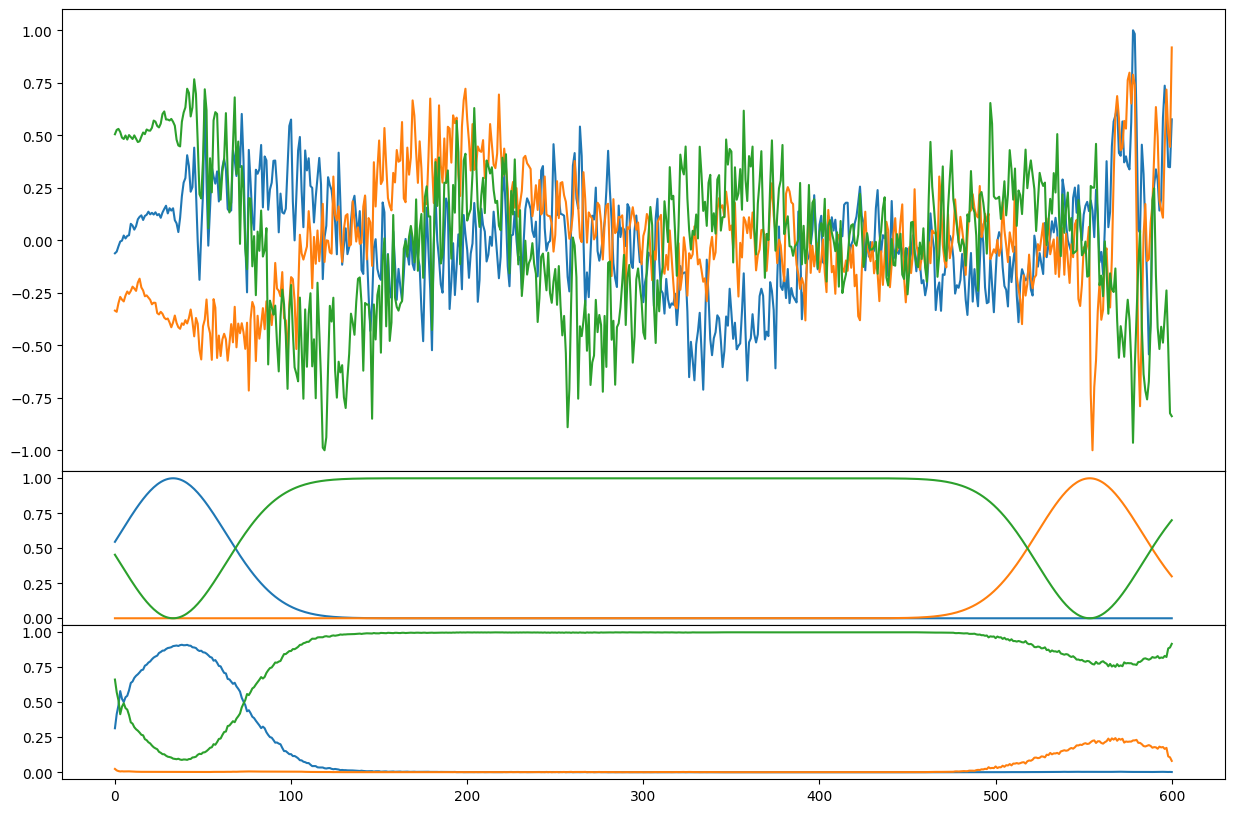

In [60]:
sample = dev_generator[np.random.randint(len(dev_generator))]

fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(3, 1, sharex=True, gridspec_kw={"hspace": 0, "height_ratios": [3, 1, 1]})
axs[0].plot(sample["X"].T)
axs[1].plot(sample["y"].T)

model.eval()  # close the model for evaluation

with torch.no_grad():
    pred = model(torch.tensor(sample["X"], device=model.device).unsqueeze(0))  # Add a fake batch dimension
    pred = pred[0].cpu().numpy()

axs[2].plot(pred.T)

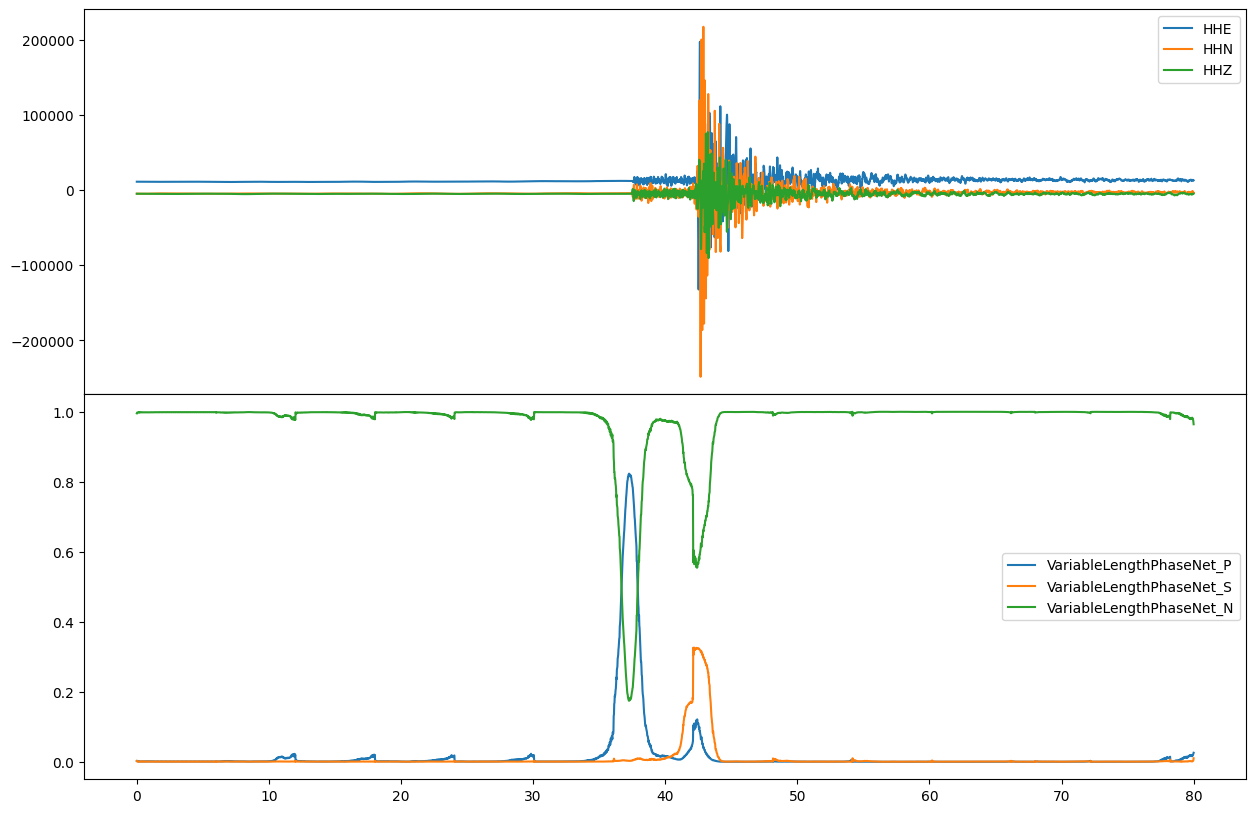

In [24]:
client = Client("ETH")

t = UTCDateTime("2019-11-04T00:59:46.419800Z")
stream = client.get_waveforms(network="CH", station="EMING", location="*", channel="HH?", starttime=t-30, endtime=t+50)

annotations = model.annotate(stream)

fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(2, 1, sharex=True, gridspec_kw={'hspace': 0})

offset = annotations[0].stats.starttime - stream[0].stats.starttime
for i in range(3):
    axs[0].plot(stream[i].times(), stream[i].data, label=stream[i].stats.channel)
    if annotations[i].stats.channel[-1] != "K":  # Do not plot noise curve
        axs[1].plot(annotations[i].times() + offset, annotations[i].data, label=annotations[i].stats.channel)

axs[0].legend()
axs[1].legend()

In [28]:
model.eval()
onnx_path = "phasenet_601samples.onnx"

In [32]:
import torch.onnx
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
dummy_input = torch.randn(1, 3, 601).to(device)

In [33]:
torch.onnx.export(
    model,
    dummy_input,
    onnx_path,
    input_names=["wave"],
    output_names=["prob"],
    opset_version=12,
    do_constant_folding=True
)

print(f"✅ ONNX berhasil diekspor ke: {onnx_path}")

✅ ONNX berhasil diekspor ke: phasenet_601samples.onnx


In [41]:
data = sample['X']
data = np.expand_dims(data, axis=0).astype(np.float32)
data.shape


(1, 3, 601)

In [42]:
import onnxruntime as ort
import numpy as np

# Buat ONNX runtime session
session = ort.InferenceSession(onnx_path)

# Ambil nama input dan output dari model
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

# Lakukan inferensi
outputs = session.run([output_name], {input_name: data})

# Output adalah array probabilitas [batch, phase, time]
print("Output shape:", outputs[0].shape)

Output shape: (1, 3, 601)


In [47]:
print(outputs[0][0].T)

[[0.03472394 0.00544276 0.95983326]
 [0.03547529 0.00357738 0.96094733]
 [0.04284916 0.00215705 0.9549938 ]
 ...
 [0.02080988 0.00343564 0.97575444]
 [0.02422404 0.00564633 0.9701296 ]
 [0.02478207 0.01112722 0.9640907 ]]


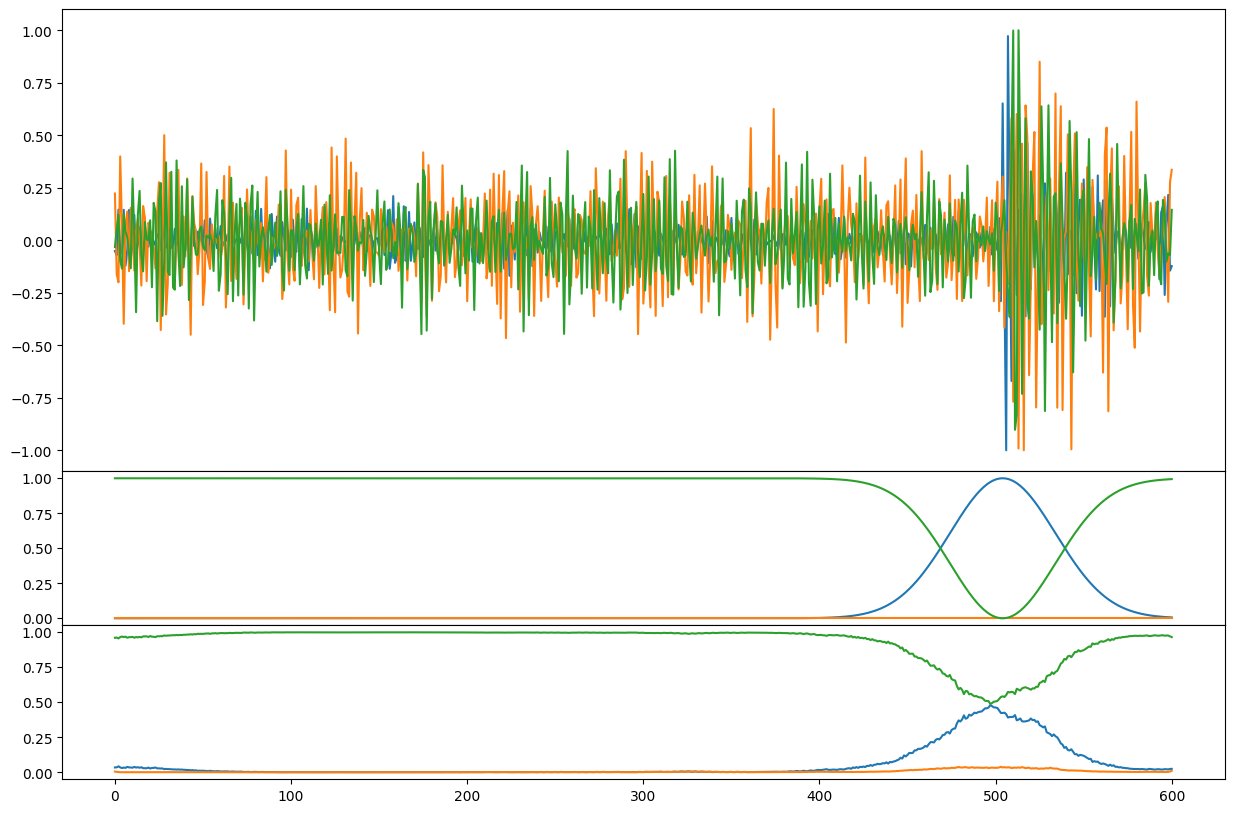

In [48]:
fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(3, 1, sharex=True, gridspec_kw={"hspace": 0, "height_ratios": [3, 1, 1]})
axs[0].plot(sample["X"].T)
axs[1].plot(sample["y"].T)

axs[2].plot(outputs[0][0].T)